## Predicting Adult Census Income Using XGBoost Tree Boosting System

## Package Requirement

## Running Preparation
**Needed Python Version:**
 > \>=3.09 
 My computer runs well in 3.11

**Needed Package:**

| Library    | Version    | Notes                    |
|------------|------------|--------------------------|
| pandas     | 2.2.2      | Recommended              |
| seaborn    | 0.13.2     | Recommended              |
| sklearn    | 1.4.0      | Recommended (1.5.0 tested OK) |
| xgboost    | 2.0.3      | Recommended              |


In [9]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

## Data Preprocessing:
### 1. Preprocessing of loading and data reformatting
XGBoost will automatically train the input data as a whole csv just like excel. To meet its requirement, we need to add trainlabel.csv's col into traindata.csv

In [10]:
# 读取 train.csv 文件
train_df = pd.read_csv("data/traindata.csv")

# 读取 data.csv 文件，假设数据列名为 'income'
data_df = pd.read_csv("data/trainlabel.csv")

# 将 'income' 数据列添加到 train_df 中
train_df['Income'] = data_df['Income']

# 将修改后的 train_df 保存为新的 CSV 文件
train_df.to_csv("data/updated_train.csv", index=False)

In [11]:
df = pd.read_csv('data/updated_train.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Income
0,77,Local-gov,177550,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,3818,0,14,United-States,0
1,40,Self-emp-inc,475322,Bachelors,13,Separated,Craft-repair,Own-child,White,Male,0,0,50,United-States,0
2,29,Self-emp-not-inc,341672,HS-grad,9,Married-spouse-absent,Transport-moving,Other-relative,Asian-Pac-Islander,Male,0,1564,50,India,1
3,41,Private,184378,HS-grad,9,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,0
4,22,Private,306967,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,25,United-States,0


### 2. Preprocessing of duplicating the same row

def duplicated(self,subset: Hashable | Sequence\[Hashable] | None = None, keep: Literal\["first", "last", False] = "first")
  
-> Series
        Return boolean Series denoting duplicate rows.
        Considering certain columns is optional.
See Also
* Index.duplicated: Equivalent method on index.
* Series.duplicated: Equivalent method on Series.
* Series.drop_duplicates: Remove duplicate values from Series.
* DataFrame.drop_duplicates: Remove duplicate values from DataFrame.

In [12]:
df.loc[df.duplicated() == True]

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Income
5721,44,Private,367749,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,45,Mexico,0
9853,25,Private,195994,1st-4th,2,Never-married,Priv-house-serv,Not-in-family,White,Female,0,0,40,Guatemala,0
15108,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,0
16958,42,Private,204235,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,1
18372,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,0
18382,23,Private,240137,5th-6th,3,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,55,Mexico,0
19488,46,Private,173243,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
19733,39,Private,30916,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
20026,27,Private,255582,HS-grad,9,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,0
20405,21,Private,243368,Preschool,1,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,50,Mexico,0


### 3. Preprocessing of transforming data and its recognition:

1. **Initialization**: 


   label_encoder = LabelEncoder()
   - Initializes a `LabelEncoder` object, which is a utility class for converting categorical labels into numerical values. It assigns a unique integer to each category in the data.

2. **Defining Categorical Columns**: 


   categorical_columns = ['Income', 'workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
   - Defines a list of column names in the DataFrame `df` that contain categorical data.

3. **Encoding Categorical Data**: 


   df[categoricalcolumns] = df[categoricalcolumns].apply(labelencoder.fittransform)
   - Applies the `fit_transform` method of the `LabelEncoder` object to each column specified in `categorical_columns`.
   - Fits the encoder to the unique categories in each column (`fit`), and then transforms the categorical labels into numerical values (`transform`).
   - Assigns these transformed values back to the respective columns in the DataFrame `df`.

Essentially, this code converts the categorical variables in the specified columns of the DataFrame into numerical representations, which can be used as input for machine learning models of XGBoost. This preprocessing step is necessary because many machine learning algorithms require numerical input data.

This Markdown format provides a structured explanation of the code snippet, making it easier to understand each step and its purpose.

In [13]:
label_encoder = LabelEncoder()
categorical_columns = ['Income', 'workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
df[categorical_columns] = df[categorical_columns].apply(label_encoder.fit_transform)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['Income']), df['Income'], test_size=0.12, random_state=38)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [15]:


xgb = XGBClassifier()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print('---- ACCURACY_SCORE ---- \n\n', accuracy_score(y_test, y_pred), '\n')
print('---- CLASSIFICATION_REPORT ---- \n\n', classification_report(y_test, y_pred))

---- ACCURACY_SCORE ---- 

 0.8779239766081871 

---- CLASSIFICATION_REPORT ---- 

               precision    recall  f1-score   support

           0       0.90      0.95      0.92      2088
           1       0.79      0.66      0.72       648

    accuracy                           0.88      2736
   macro avg       0.84      0.80      0.82      2736
weighted avg       0.87      0.88      0.87      2736


## Confusion Matrix
The confusion matrix is a commonly used tool to evaluate the performance of a classification model, especially in multi-class classification problems. It illustrates the relationship between the model's predictions on the test set and the true labels.

The primary purpose of the confusion matrix is to provide an intuitive understanding of the classification model's performance, particularly in terms of misclassifications between different classes. From the confusion matrix, we can comprehensively evaluate the model's performance.

<Axes: >

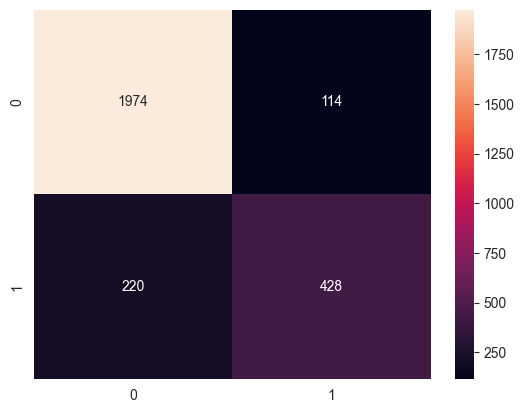

In [16]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

## Data Explanation

1. The number 1974 in the top-left corner represents the count of true negatives (TN), indicating instances where the true class is negative, and the model correctly predicted them as negative.
2. The number 114 in the top-right corner represents the count of false positives (FP), indicating instances where the true class is negative, but the model incorrectly predicted them as positive.
3. The number 220 in the bottom-left corner represents the count of false negatives (FN), indicating instances where the true class is positive, but the model incorrectly predicted them as negative.
4. The number 428 in the bottom-right corner represents the count of true positives (TP), indicating instances where the true class is positive, and the model correctly predicted them as positive.